<a href="https://colab.research.google.com/github/merveenoyan/smollm/blob/main/vision/finetuning/Smol_VLM_FT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q accelerate datasets peft bitsandbytes tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.9 MB/s eta 0:00:00


In [2]:
!pip install -q flash-attn==2.7.3 #--no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 35.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
pip install -U datasets

In [4]:
import matplotlib.pyplot as plt
import os
from huggingface_hub import login
import torch
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from transformers import AutoProcessor, BitsAndBytesConfig, Idefics3ForConditionalGeneration, TrainingArguments, Trainer
from datasets import load_dataset
import numpy as np
import torch
from tqdm import tqdm
from PIL import Image
import re

In [ ]:
os.environ["HF_TOKEN"] = ""
login(token=os.environ["HF_TOKEN"], add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [6]:
USE_LORA = False
USE_QLORA = True
SMOL = True

model_id = "HuggingFaceTB/SmolVLM-Base" if SMOL else "HuggingFaceM4/Idefics3-8B-Llama3"

processor = AutoProcessor.from_pretrained(
    model_id
)

if USE_QLORA or USE_LORA:
    lora_config = LoraConfig(
        r=8,
        lora_alpha=8,
        lora_dropout=0.1,
        target_modules=['down_proj','o_proj','k_proj','q_proj','gate_proj','up_proj','v_proj'],
        use_dora=False if USE_QLORA else True,
        init_lora_weights="gaussian"
    )
    lora_config.inference_mode = False
    if USE_QLORA:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16
        )

    model = Idefics3ForConditionalGeneration.from_pretrained(
        model_id,
        quantization_config=bnb_config if USE_QLORA else None,
        _attn_implementation="flash_attention_2",
        device_map="auto"
    )
    model.add_adapter(lora_config)
    model.enable_adapters()
    model = prepare_model_for_kbit_training(model)
    model = get_peft_model(model, lora_config)
    print(model.get_nb_trainable_parameters())
else:
    model = Idefics3ForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16,
        _attn_implementation="flash_attention_2",
    ).to(DEVICE)


    for param in model.model.vision_model.parameters():
        param.requires_grad = False

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/424 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/4.49G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:190: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


(10536960, 2256809840)


The model as is is holding 2.7 GB of GPU RAM 💗

## Loading the dataset and Preprocessing

In [7]:
repo_id = "Harsh9699/Stanford_car_75_25_split"
ds = load_dataset(repo_id)

# Get class names from the dataset features
label_feature = ds["train"].features["label"]
class_names = label_feature.names

# Add class names to the dataset
def add_class_name(example):
    example["class_name"] = class_names[example["label"]]
    return example

ds = ds.map(add_class_name)

# Use only training split
train_ds = ds["train"]

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00003.parquet:   0%|          | 0.00/456M [00:00<?, ?B/s]

data/train-00001-of-00003.parquet:   0%|          | 0.00/442M [00:00<?, ?B/s]

data/train-00002-of-00003.parquet:   0%|          | 0.00/594M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12084 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4131 [00:00<?, ? examples/s]

Map:   0%|          | 0/12084 [00:00<?, ? examples/s]

Map:   0%|          | 0/4131 [00:00<?, ? examples/s]

In [8]:
# COLLATE FUNCTION
image_token_id = processor.tokenizer.additional_special_tokens_ids[
    processor.tokenizer.additional_special_tokens.index("<image>")]

def collate_fn(examples):
    texts = []
    images = []
    for example in examples:
        image = example["image"]
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Use car class name from the new column
        car_class = example["class_name"]

        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "What is the make, model, and year of this car?"},
                    {"type": "image"}
                ]
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": car_class}
                ]
            }
        ]
        text = processor.apply_chat_template(messages, add_generation_prompt=False)
        texts.append(text.strip())
        images.append([image])

    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    labels[labels == image_token_id] = -100
    batch["labels"] = labels

    return batch

## Training

In [9]:
from transformers import TrainingArguments, Trainer

model_name = model_id.split("/")[-1]

training_args = TrainingArguments(
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    warmup_steps=50,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=25,
    save_strategy="steps",
    save_steps=250,
    save_total_limit=1,
    optim="paged_adamw_8bit",
    bf16=True,
    output_dir=f"./{model_name}-vqav2",
    hub_model_id=f"{model_name}-vqav2",
    report_to="tensorboard",
    remove_unused_columns=False,
    gradient_checkpointing=True
)


In [10]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_ds,
)

No label_names provided for model class `PeftModel`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [11]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
Casting fp32 inputs back to torch.bfloat16 for flash-attn compatibility.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
25,0.897200
50,0.299600
75,0.096200
100,0.043400
125,0.122700
150,0.019600
175,0.012300
200,0.010200
225,0.009700
250,0.008600


TrainOutput(global_step=756, training_loss=0.05578394954230775, metrics={'train_runtime': 10534.8157, 'train_samples_per_second': 1.147, 'train_steps_per_second': 0.072, 'total_flos': 2.029187747096375e+17, 'train_loss': 0.05578394954230775, 'epoch': 1.0})

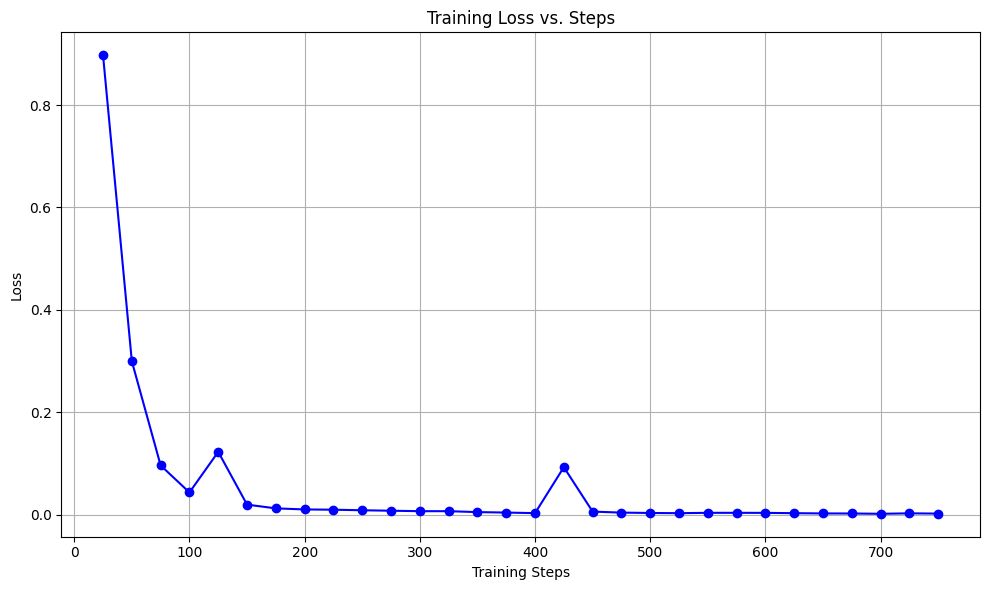

In [12]:
# Extract training logs
train_logs = trainer.state.log_history

# Prepare data for plotting
steps = []
losses = []
for log in train_logs:
    if 'loss' in log:
        steps.append(log['step'])
        losses.append(log['loss'])

# Create and save plot
plt.figure(figsize=(10, 6))
plt.plot(steps, losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss vs. Steps')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()

# Save plot to file
plt.savefig('training_loss.png')
plt.show()

In [13]:
trainer.push_to_hub("Harsh9699/fine_tune_smolVLM")

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ase-vqav2/adapter_model.safetensors:   0%|          | 71.6kB / 42.2MB            

  ...ents.1753947952.ef82da194700.2406.0:   9%|9         | 1.43kB / 15.6kB            

  ...molVLM-Base-vqav2/training_args.bin:   9%|9         |   491B / 5.37kB            

CommitInfo(commit_url='https://huggingface.co/Harsh9699/SmolVLM-Base-vqav2/commit/4ff8a5cc0886782127a579e62de866311669aa25', commit_message='Harsh9699/fine_tune_smolVLM', commit_description='', oid='4ff8a5cc0886782127a579e62de866311669aa25', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Harsh9699/SmolVLM-Base-vqav2', endpoint='https://huggingface.co', repo_type='model', repo_id='Harsh9699/SmolVLM-Base-vqav2'), pr_revision=None, pr_num=None)

In [14]:
def evaluate_model(model, processor, dataset, num_samples=50):
    """
    Evaluate fine-tuned model on random samples and display results

    """
    # Set model to evaluation mode
    model.eval()

    # Select random samples and convert indices to Python integers
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    samples = [dataset[int(i)] for i in indices]  # Convert numpy int to Python int

    # Storage for results
    predictions = []
    actuals = []
    images = []

    # Generate predictions
    with torch.no_grad():
        for sample in tqdm(samples, desc="Evaluating samples"):
            # Get image and convert to RGB
            image = sample["image"]
            if image.mode != 'RGB':
                image = image.convert('RGB')

            # Get actual class name
            actual_class = sample["class_name"]
            actuals.append(actual_class)
            images.append(image.copy())

            # Create prompt
            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": "What is the make, model, and year of this car?"},
                        {"type": "image"}
                    ]
                }
            ]
            text = processor.apply_chat_template(messages, add_generation_prompt=True)

            # Process inputs
            inputs = processor(text=text, images=[image], return_tensors="pt", padding=True)
            inputs = {k: v.to(model.device) for k, v in inputs.items()}

            # Generate predictions
            outputs = model.generate(
                **inputs,
                max_new_tokens=50,
                pad_token_id=processor.tokenizer.pad_token_id
            )

            # Decode predictions
            pred_text = processor.batch_decode(outputs, skip_special_tokens=True)[0]



            if "assistant" in pred_text:
                # Split after the last "assistant" occurrence
                assistant_response = pred_text.split("assistant")[-1].strip()

                # Remove any special tokens or prefixes
                assistant_response = re.sub(r'^[\s<]*', '', assistant_response)
                assistant_response = re.sub(r'<[^>]*>', '', assistant_response)
                assistant_response = assistant_response.strip()
            else:
                # If we can't find "assistant", use the whole text
                assistant_response = pred_text.strip()

            predictions.append(assistant_response)

    # Calculate accuracy - use case-insensitive comparison
    correct = 0
    comparison_results = []

    for p, a in zip(predictions, actuals):
        # Normalize strings for comparison
        p_norm = p.lower().strip()
        a_norm = a.lower().strip()

        # Check if predicted string contains actual string or vice versa
        match = (p_norm == a_norm) or (a_norm in p_norm) or (p_norm in a_norm)
        comparison_results.append(match)
        if match:
            correct += 1

    accuracy = correct / num_samples

    # Create visualization
    plt.figure(figsize=(20, 15))
    plt.suptitle(f"Model Evaluation - Accuracy: {accuracy:.1%} ({correct}/{num_samples})",
                 fontsize=16, y=0.98)

    for i in range(num_samples):
        plt.subplot(5, 2, i+1)
        plt.imshow(images[i])

        # Highlight correct predictions in green, incorrect in red
        color = "green" if comparison_results[i] else "red"
        plt.title(f"Actual: {actuals[i]}\nPredicted: {predictions[i]}",
                  fontsize=12, color=color)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    # Print detailed comparison for debugging
    print("\nDetailed Predictions:")
    print("-" * 80)
    for i in range(num_samples):
        match_status = "✓" if comparison_results[i] else "✗"
        print(f"Sample {i+1}: {match_status}")
        print(f"  Actual:    {actuals[i]}")
        print(f"  Predicted: {predictions[i]}")
        print("-" * 80)

    return accuracy

Evaluating samples: 100%|██████████| 50/50 [01:49<00:00,  2.19s/it]


ValueError: num must be an integer with 1 <= num <= 10, not 11

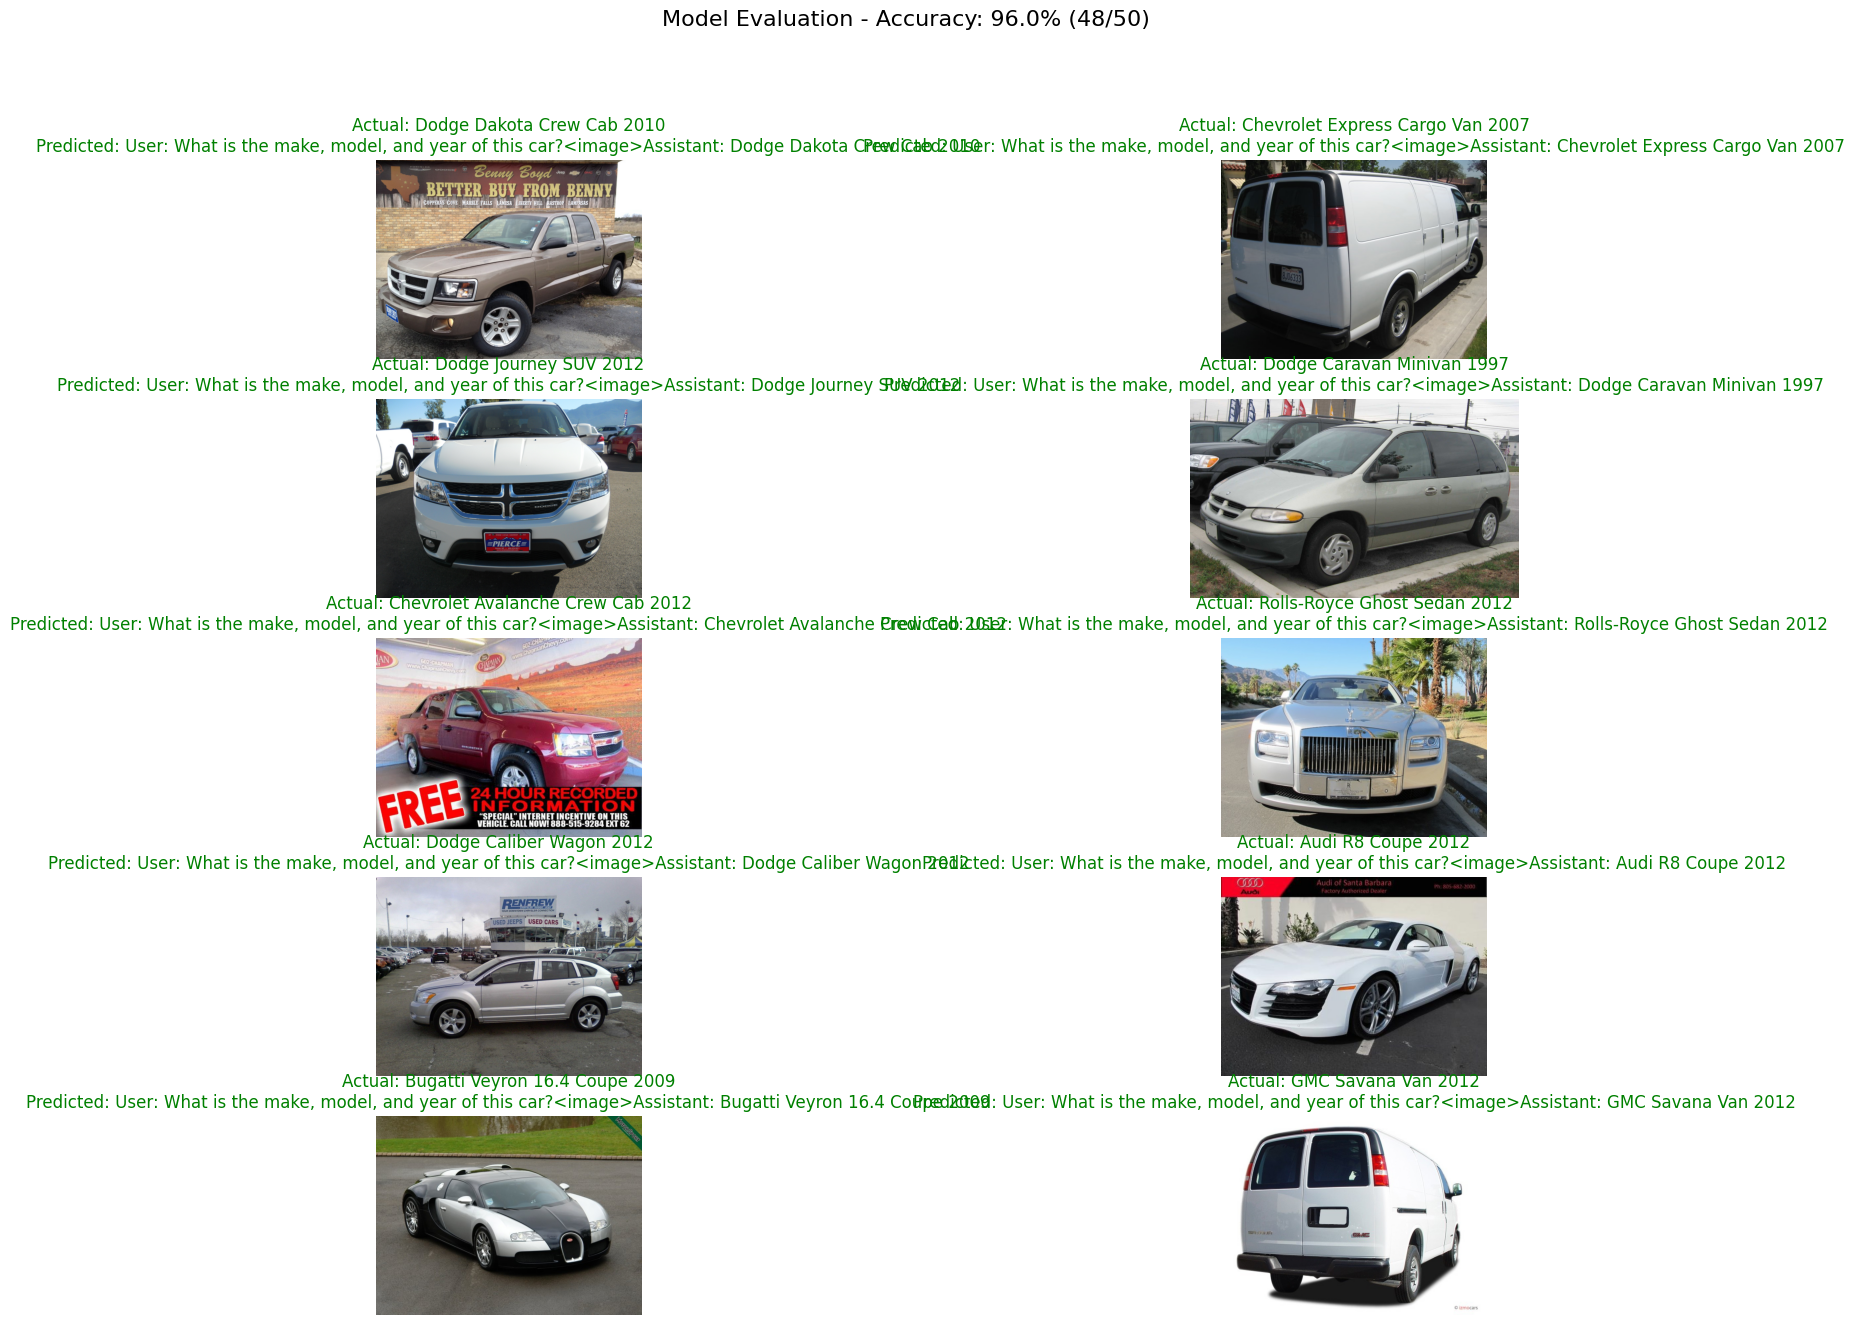

In [15]:
# Run evaluation on test set
accuracy = evaluate_model(
    model=model,
    processor=processor,
    dataset=ds["test"]
)

print(f"Final Accuracy: {accuracy:.2%}")